In [9]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer
from bayes_opt import BayesianOptimization
from sklearn.linear_model import Ridge

import pandas as pd
import numpy as np
import dill
import time

seed = 101 # Lucky seed

In [2]:
def dump_dill(fname, obj):
    with open(fname, 'wb') as f:
        dill.dump(obj, f)
    return None

def split_cat(text):
    try:
        result = text.split('/')
    except:
        result = ['missing','missing','missing']
    return result[:3]

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.key].values
    
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)
    
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

In [3]:
df = pd.read_table('data/train.tsv', index_col='train_id')
df.head()

C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\numpy\lib\arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


Let's start by transforming the price.

In [4]:
y = np.log1p(df['price'].values)
y

array([ 2.39789527,  3.97029191,  2.39789527, ...,  2.56494936,
        3.8286414 ,  3.13549422])

Now let's split the categories.

In [5]:
cats = np.vstack(df['category_name'].map(split_cat).values)
df['cat_0'] = cats[:,0]
df['cat_1'] = cats[:,1]
df['cat_2'] = cats[:,2]
del df['category_name']
df.head()

,name,item_condition_id,brand_name,price,shipping,item_description,cat_0,cat_1,cat_2
train_id,,,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


Fill missing values in brand_name and item_description.

In [6]:
df['brand_name'].fillna('missing', inplace=True)
df['item_description'].fillna('missing', inplace=True)

Build a feature pipeline (to allow for proper cross-validation).

In [7]:
pipe_0 = Pipeline([('select', ItemSelector('name')), ('vect', CountVectorizer())])
pipe_1 = Pipeline([('select', ItemSelector('item_description')), ('vect', CountVectorizer())])
pipe_2 = Pipeline([('select', ItemSelector('brand_name')), ('enc', LabelBinarizerPipelineFriendly(sparse_output=True))])
pipe_3 = Pipeline([('select', ItemSelector('cat_0')), ('enc', LabelBinarizerPipelineFriendly(sparse_output=True))])
pipe_4 = Pipeline([('select', ItemSelector('cat_1')), ('enc', LabelBinarizerPipelineFriendly(sparse_output=True))])
pipe_5 = Pipeline([('select', ItemSelector('cat_2')), ('enc', LabelBinarizerPipelineFriendly(sparse_output=True))])
pipe_6 = Pipeline([('select', ItemSelector(['item_condition_id', 'shipping']))])
feats = FeatureUnion([('name_feat', pipe_0),
                      ('item_description_feat', pipe_1),
                      ('brand_name_feat', pipe_2),
                      ('cat_0', pipe_3),
                      ('cat_1', pipe_4),
                      ('cat_2', pipe_5),
                      ('ship_condition', pipe_6)])
pipe = Pipeline([('feats',feats), ('model',Ridge())])

Define a custom scoring metric and run Grid Search to optimize Ridge.

In [19]:
from sklearn.linear_model import SGDRegressor

neg_rmsle = make_scorer(rmsle, greater_is_better=False)
pipe = Pipeline([('feats',feats), ('model',SGDRegressor(max_iter=5, random_state=seed))])

params = {'model__alpha':np.logspace(-6,0,20)}
gs = GridSearchCV(estimator=pipe,
                  param_grid=params,
                  scoring=neg_rmsle,
                  n_jobs=1,
                  cv=2,
                  verbose=3,
                  refit=False,
                  return_train_score=True)

gs.fit(df, y)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] model__alpha=1e-06 ..............................................
[CV] .... model__alpha=1e-06, score=-0.5075415461203104, total=  56.0s
[CV] model__alpha=1e-06 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] .... model__alpha=1e-06, score=-0.5084430228270768, total=  55.6s
[CV] model__alpha=2.06913808111e-06 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.7min remaining:    0.0s


KeyboardInterrupt: 

C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\King\A

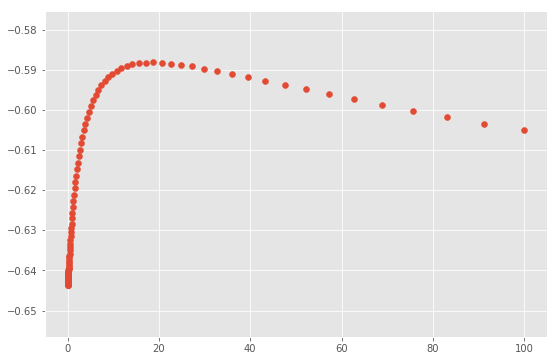

In [19]:
gs_results = pd.DataFrame(gs.cv_results_)
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.scatter(gs_results['param_model__alpha'].values, gs_results['mean_test_score'].values)
plt.show()

In [25]:
from scipy.stats import logistic, lognorm, uniform

lognorm.rvs()

5.2649603247777984e+102

In [63]:
from scipy.stats import logistic, lognorm, uniform

rs_params = {'model__alpha':np.logspace(-6,0,200)}
rs = RandomizedSearchCV(estimator=pipe,
                        param_distributions=rs_params,
                        n_iter=5,
                        scoring=neg_rmsle,
                        n_jobs=1,
                        cv=2,
                        verbose=3,
                        refit=False,
                        return_train_score=True)

rs.fit(df.iloc[:10000], y[:10000])

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] model__alpha=1.74263338601e-06 ..................................
[CV]  model__alpha=1.74263338601e-06, score=-0.6962268695513488, total=   0.2s
[CV] model__alpha=1.74263338601e-06 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  model__alpha=1.74263338601e-06, score=-0.6761338839605696, total=   0.2s
[CV] model__alpha=0.143145893752 .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  model__alpha=0.143145893752, score=-0.9706913278734028, total=   0.2s
[CV] model__alpha=0.143145893752 .....................................
[CV]  model__alpha=0.143145893752, score=-0.9523451866093765, total=   0.2s
[CV] model__alpha=0.0289942285388 ....................................
[CV]  model__alpha=0.0289942285388, score=-0.7610452954443745, total=   0.2s
[CV] model__alpha=0.0289942285388 ....................................
[CV]  model__alpha=0.0289942285388, score=-0.7391374902985209, total=   0.2s
[CV] model__alpha=0.286606761695 .....................................
[CV]  model__alpha=0.286606761695, score=-1.1143683067461458, total=   0.2s
[CV] model__alpha=0.286606761695 .....................................
[CV]  model__alpha=0.286606761695, score=-1.0976390966050082, total=   0.2s
[CV] model__alpha=0.17629141181 ......................................
[CV]  model__alpha=0.17629141181, score=-1.011424537154632, total=   0.2s
[CV] model__alpha=0.17629141181 ..........

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished


RandomizedSearchCV(cv=2, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('name_feat', Pipeline(memory=None,
     steps=[('select', ItemSelector(key='name')), ('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content'...       power_t=0.25, random_state=101, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'model__alpha': array([  1.00000e-06,   1.07189e-06, ...,   9.32930e-01,   1.00000e+00])},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,
          return_train_score=True,
          scoring=make_scorer(rmsle, greater_is_better=False), verbose=3)

In [64]:
x_init = [t['model__alpha'] for t in rs.cv_results_['params']]
y_init = rs.cv_results_['mean_test_score']

In [68]:
from sklearn.model_selection import cross_val_score

def score(alpha):
    pipe = Pipeline([('feats',feats), ('model',Ridge(alpha=alpha))])
    return cross_val_score(pipe, df.iloc[:10000], y[:10000], scoring=neg_rmsle, cv=2).mean()

bo = BayesianOptimization(score, pbounds={'alpha':(1e-6,1)})
bo.initialize({'target':y_init, 'alpha':x_init})

In [69]:
bo.maximize(init_points=0, n_iter=10, acq='ei', kappa=5)

Initialization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
    1 | 00m00s |   -0.68618 |    0.0000 | 
    2 | 00m00s |   -0.96152 |    0.1431 | 
    3 | 00m00s |   -0.75009 |    0.0290 | 
    4 | 00m00s |   -1.10600 |    0.2866 | 
    5 | 00m00s |   -1.00256 |    0.1763 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
    6 | 00m03s |   -0.62623 |    1.0000 | 
    7 | 00m04s |   -0.62794 |    0.8941 | 
    8 | 00m03s |   -0.62692 |    0.9472 | 
    9 | 00m04s |   -0.62948 |    0.7928 | 
   10 | 00m04s |   -0.62866 |    0.8335 | 
   11 | 00m03s |   -0.62643 |    0.9817 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\bayes_opt\helpers.py:109: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


   12 | 00m03s |   -0.63078 |    0.7164 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014942]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


   13 | 00m03s |   -0.62995 |    0.7476 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\bayes_opt\helpers.py:109: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


   14 | 00m03s |   -0.62616 |    0.9956 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\bayes_opt\helpers.py:109: RuntimeWarning: divide by zero encountered in true_divide
  z = (mean - y_max - xi)/std


   15 | 00m03s |   -0.62636 |    0.9941 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00062997]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00110592]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00188476]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gauss

C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\King\A

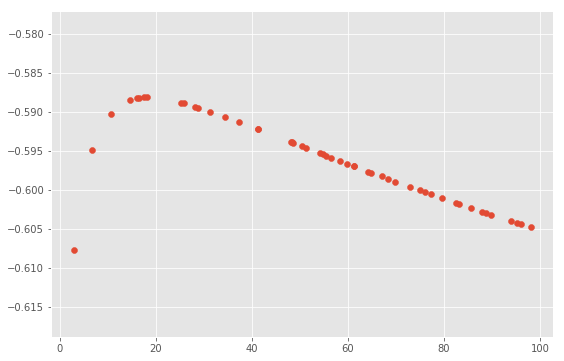

In [31]:
rs_results = pd.DataFrame(rs.cv_results_)

plt.style.use('ggplot')
plt.figure(figsize=(9,6))
plt.scatter(rs_results['param_model__alpha'].values, rs_results['mean_test_score'].values)
plt.show()

In [54]:
from sklearn.model_selection import cross_val_score

def score(alpha):
    pipe = Pipeline([('feats',feats), ('model',Ridge(alpha=alpha))])
    return cross_val_score(pipe, df.iloc[:10000], y[:10000], scoring=neg_rmsle, cv=2).mean()

bo = BayesianOptimization(score, pbounds={'alpha':(0,100)})

In [55]:
bo.maximize(init_points=10, n_iter=10, acq='ei', kappa=5)

Initialization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
    1 | 00m01s |   -0.58886 |   26.0293 | 
    2 | 00m01s |   -0.58895 |   26.5237 | 
    3 | 00m00s |   -0.59253 |   42.7224 | 
    4 | 00m00s |   -0.60047 |   77.2834 | 
    5 | 00m00s |   -0.60301 |   89.3776 | 
    6 | 00m00s |   -0.60422 |   95.5677 | 
    7 | 00m00s |   -0.59197 |   40.4996 | 
    8 | 00m01s |   -0.58901 |   26.6608 | 
    9 | 00m00s |   -0.60057 |   77.8607 | 
   10 | 00m01s |   -0.58901 |   26.9083 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.34427100e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00038445]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00046084]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 116, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |     alpha | 
   11 | 00m05s |   -0.64192 |    0.0856 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00015255]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00162287]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00390254]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gauss

   12 | 00m03s |   -0.58860 |   24.5675 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0024099]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 135, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -8.29474156e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00065932]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\

   13 | 00m02s |   -0.58834 |   22.7331 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.01371289]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00350404]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00043229]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 75, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gauss

   14 | 00m04s |   -0.58837 |   22.7034 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00097401]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00749572]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 155, 'nit': 12, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00063425]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gau

   15 | 00m05s |   -0.58823 |   21.8158 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01465309]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00105188]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00380263]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gauss

   16 | 00m03s |   -0.58811 |   20.2668 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00068566]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 94, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00272495]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00492214]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gauss

   17 | 00m02s |   -0.58807 |   19.6891 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.01426841]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 121, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00035733]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 102, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00088564]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 91, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gau

   18 | 00m05s |   -0.58808 |   19.5457 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -6.27154368e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 95, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.73856882e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  7.38718081e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-package

   19 | 00m05s |   -0.58808 |   20.0105 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00112168]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00393765]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 98, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.00045682]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gauss

   20 | 00m05s |   -0.58817 |   21.1547 | 


C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.02846278]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00024517]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 99, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00049477]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 111, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\King\Anaconda3\envs\bayes_opt\lib\site-packages\sklearn\gaus

In [56]:
bo.res['max']

{'max_params': {'alpha': 19.689099412796718}, 'max_val': -0.58806930988691541}

In [57]:
gs.best_score_

-0.58803526161488695

In [58]:
rs.best_score_

-0.58805167226813915